# PCA using Sentinel-2

Authors:

* Jeroen Wannijn

# Introduction
In this notebook, we will perform dimensionality reduction analysis on a full data cube of preprocessed Sentinel data for the WEED project. The data has been retrieved from and processed on openEO. The models we use are pretrained and generated with Scikit-learn. This notebook focuses primarily on the implementation of the model and the subsequent analysis. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
import rasterio
import requests
import xarray as xr
import openeo
from eo_processing.openeo.processing import generate_master_feature_cube
from sklearn.decomposition import tsne 

# openeo version
openeo.client_version()

'0.40.0'

Creates a output directory if it doesn't exist.

In [51]:
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [52]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

In [53]:
BBOX = {"east": 4879000, "south": 2897000, "west": 4877000, "north": 2899000, 'crs': 'EPSG:3035'} # 2x2km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2021-03-01"

*Select usable observations*:

For this exercise we use the bands and derivatives of a master feature cube of the weed Project, which has 273 variables in total, ideal for a dimensionality reduction.

In [54]:
sentinel_master_cube = generate_master_feature_cube(
        connection=eoconn,
        S1_collection='SENTINEL1_GRD',
        S2_collection='SENTINEL2_L2A',
        bbox=BBOX,
        start=DATE_START,
        end=DATE_END)


In [40]:
sentinel_master_cube.download(base_path / "sentinel_cube.nc")

## Visualise RGB to get a view of the area
Load RGB data from Sentinel-2 collection

In [ ]:
rgb_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent="2021",
    bands=['B02', 'B03', 'B04']
)

# Reduce to a single time slice, e.g. take median over time to get 2D image
rgb_cube = rgb_cube.reduce_dimension(dimension='t', reducer='mean')


Download Sentinel-2 RGB data

In [ ]:
# rgb_cube.download(base_path / "rgb_cube.tiff")

Visualize RGB data

Pixel Size: 10.0 x 10.0 units


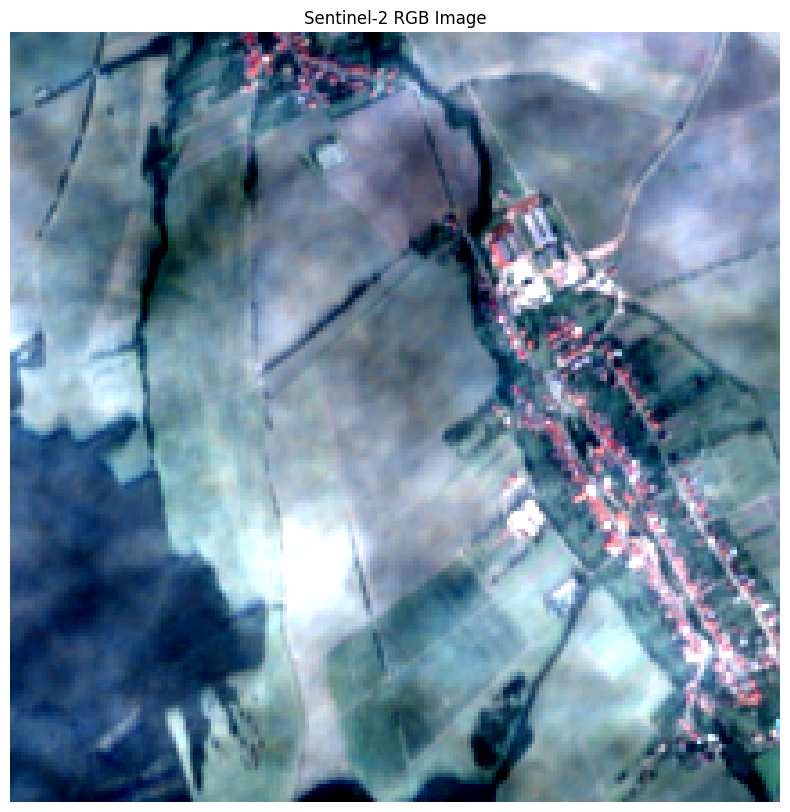

In [56]:
with rasterio.open(base_path / "rgb_cube.tiff") as src:
    pixel_size_x = src.transform.a
    pixel_size_y = -src.transform.e
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    r = src.read(3)  # Band 4
    g = src.read(2)  # Band 3
    b = src.read(1)  # Band 2

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize using percentiles
def normalize_percentile(img, lower=2, upper=98):
    p_low, p_high = np.percentile(img, (lower, upper))
    img_clipped = np.clip(img, p_low, p_high)
    return (img_clipped - p_low) / (p_high - p_low)

rgb_norm = normalize_percentile(rgb_img)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## Calculate PCA & T-SNE


Load test training models. The PCA model is trained for 4 components and the t-SNE model is trained for 3 components.

In [ ]:
pca_model_url = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/tsne/dim_reduction_pca.pkl"
tsne_model_url = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/PCA/dim_reduction_tsne.pkl"

### run locally

In [ ]:
# Open Sentinel Cube as Input
ds = xr.open_dataset(base_path / "sentinel_cube.nc")

# Assume the relevant DataArray is called "cube"

band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]
print(f"Selected input {len(band_vars)} bands")
cube = xr.concat([ds[var] for var in band_vars], dim="bands")
cube = cube.rename('__xarray_dataarray_variable__')

cube = cube.assign_coords(bands=band_vars)  # name the bands

Selected input 237 bands
<xarray.DataArray 'desired_name' (bands: 237, y: 214, x: 214)> Size: 43MB
array([[[2.7460001e-02, 2.7799999e-02, 2.4400000e-02, ...,
         3.9200000e-02, 3.6240000e-02, 3.3720002e-02],
        [3.1339999e-02, 2.9420000e-02, 2.6300000e-02, ...,
         3.4680001e-02, 3.2499999e-02, 2.9600000e-02],
        [2.8160000e-02, 2.8500000e-02, 2.7319999e-02, ...,
         3.5439998e-02, 3.7280001e-02, 3.0980000e-02],
        ...,
        [1.3800000e-02, 8.8000000e-03, 6.5199998e-03, ...,
         1.3599999e-02, 2.1219999e-02, 2.3720000e-02],
        [1.4400000e-02, 1.0900000e-02, 4.5400001e-03, ...,
         1.9260000e-02, 3.0280000e-02, 3.1800002e-02],
        [1.0740000e-02, 1.1960000e-02, 9.2000002e-03, ...,
         2.2040000e-02, 3.6800001e-02, 3.2979999e-02]],

       [[5.1899999e-02, 4.9450003e-02, 4.9699999e-02, ...,
         5.7400003e-02, 5.4299999e-02, 5.5000000e-02],
        [5.0200000e-02, 5.1700000e-02, 4.9500000e-02, ...,
         5.6100000e-02, 5.015

In [ ]:
from udf_dim_reduction import apply_datacube # This module MUST exist in your environment

# Open Sentinel Cube as Input
ds = xr.open_dataset(base_path / "sentinel_cube.nc")

# Assume the relevant DataArray is called "cube"
def concat_feautures_to_bands_dim(ds: xr.DataArray):
    band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]
    print(f"Selected input {len(band_vars)} bands")

    cube = xr.concat([ds[var] for var in band_vars], dim="bands")
    cube = cube.assign_coords(bands=band_vars)  # name the bands
    return cube.rename('__xarray_dataarray_variable__')

def run_locally(cube: xr.DataArray, model_url: str, output_name: str):
    # Use the PCA model
    context = {"model_url": model_url}
    result = apply_datacube(cube, context)

    result.to_netcdf(base_path / output_name )

#Preprocess
cube = concat_feautures_to_bands_dim(ds)

# PCA
run_locally(cube, pca_model_url, "components_pca_local_test.nc")

## T-SNE
# run_locally(cube, tsne_model_url, "components_tsne_local.nc")


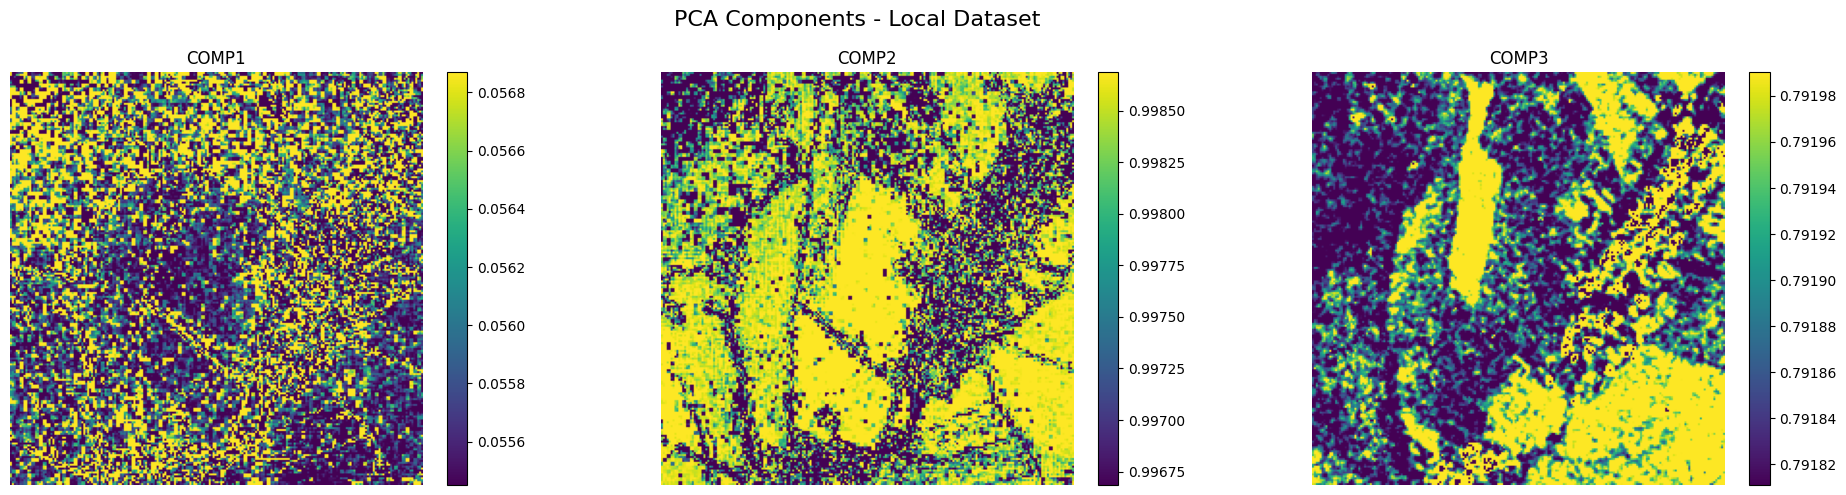

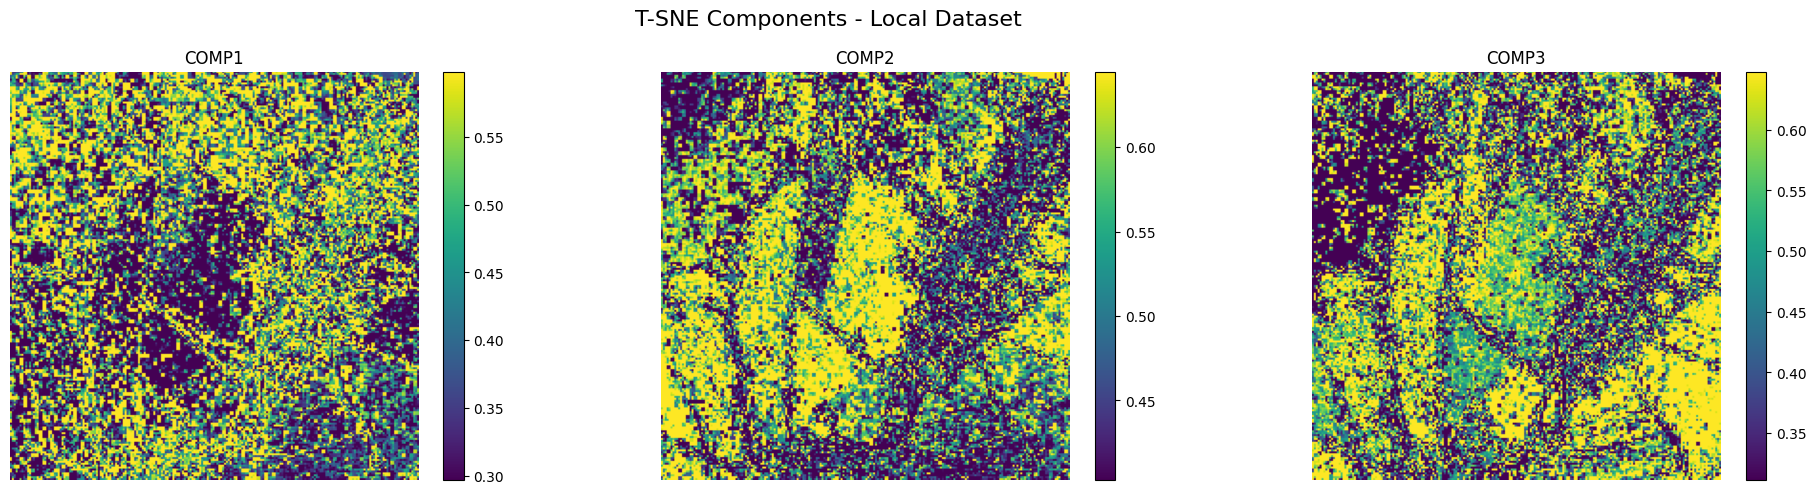

In [124]:
pca_local_data = xr.open_dataset(base_path / "components_pca_local_test.nc")
pca_data_array = pca_local_data['__xarray_dataarray_variable__']

tsne_local_data = xr.open_dataset(base_path / "tsne_components_local.nc")
tsne_data_array = tsne_local_data['__xarray_dataarray_variable__']

def plot_components(data_array: str, model_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, ax in enumerate(axes):
        comp_data = data_array.isel(bands=i)
        # Use percentiles to plot as vmin & vmax to highlight differences
        vmin = comp_data.quantile(0.25).item()
        vmax = comp_data.quantile(0.75).item()
        
        im = ax.imshow(comp_data, origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f'COMP{i+1}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add a general title
    fig.suptitle(model_name + " Components - Local Dataset", fontsize=16)

    plt.tight_layout()
    plt.show()

plot_components(pca_data_array, "PCA")
plot_components(tsne_data_array, "T-SNE")

### Statistical figures

Open locally saved files

In [89]:
# Download the pickle file
response = requests.get(pca_model_url)

# Save the pickle to disk locally
with open(base_path / "test_dim_reduction_pca.pkl", "wb") as f:
    f.write(response.content)

# Load model with pickle
with open(base_path / "test_dim_reduction_pca.pkl", "rb") as f:
    model_reloaded = pickle.load(f) # Make sure the source module is available

Explained Variance Ratio by Principal Component of PCA (4 components)

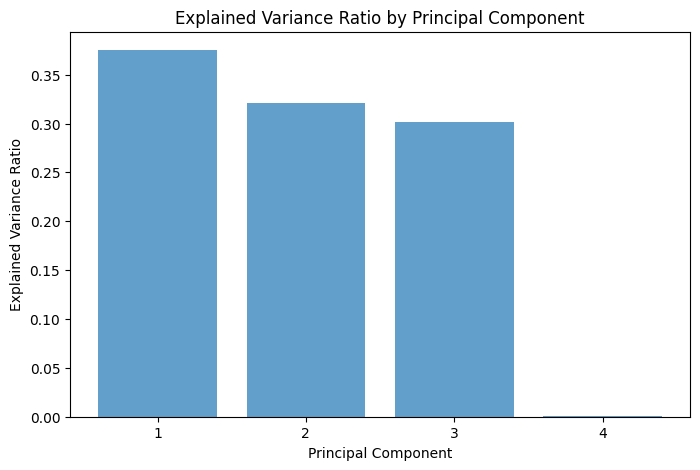

In [ ]:
explained_variance_ratio = model_reloaded.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

Cumulative Explained Variance by Number of PCA Components

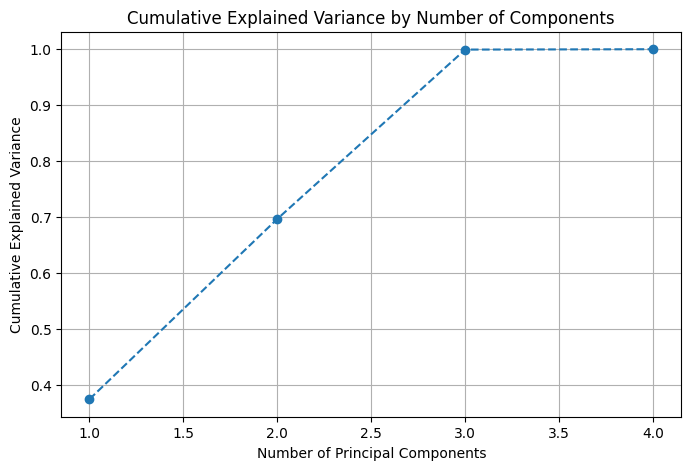

In [91]:
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

Heatmap of the most significant parameters of the PCA-model

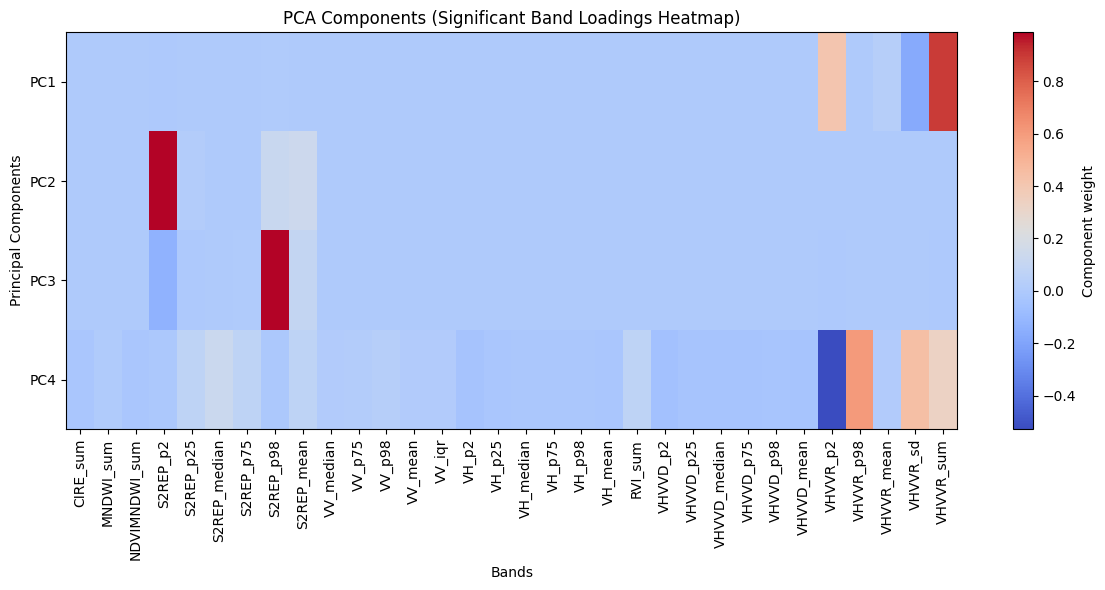

In [92]:
components = model_reloaded.components_  # shape: (n_components, n_bands)
original_band_names= sentinel_master_cube.metadata.band_names

threshold = 0.01 # define significance threshold

# Find bands with at least one loading above threshold (in absolute value)
significant_bands_mask = np.any(np.abs(components) >= threshold, axis=0)

# Filter components to keep only significant bands
components_filtered = components[:, significant_bands_mask]

# Get only significant band names for the x-axis labels
significant_band_names = [original_band_names[i] for i in np.where(significant_bands_mask)[0]]

plt.figure(figsize=(12, 6))
plt.imshow(components_filtered, aspect='auto', cmap='coolwarm')
plt.colorbar(label='Component weight')

plt.xlabel('Bands')
plt.ylabel('Principal Components')
plt.title('PCA Components (Significant Band Loadings Heatmap)')
plt.yticks(ticks=np.arange(components_filtered.shape[0]), labels=[f'PC{i+1}' for i in range(components_filtered.shape[0])])

# Use the original band names instead of generic ones
plt.xticks(ticks=np.arange(components_filtered.shape[1]), 
           labels=significant_band_names, 
           rotation=90)

plt.tight_layout()
plt.show()

### run through connection

In [94]:
job_options = {
    "driver-memory": "4G",
    "driver-memoryOverhead": "4G",
    "driver-cores": "1",
    "executor-memory": "2000m",
    "executor-memoryOverhead": "256m",
    "python-memory": "4G",
    "executor-cores": "1",
    "max-executors": "20",
    "logging-threshold": "info"
 }

In [ ]:
## Apply the Dimensionality Reduction UDF with PCA using `apply`
pca_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   runtime="Python",
                                   version="3.8.8",
                                   context={"model_url": pca_model_url})
components = sentinel_master_cube.apply(
    process=pca_udf_obj,
)
pca_job = components.create_job(
    title="pca_job", out_format="NetCDF", job_options=job_options
)
pca_job.start_and_wait()

0:00:00 Job 'j-2506171049484591be730cabbd38ca65': send 'start'
0:00:13 Job 'j-2506171049484591be730cabbd38ca65': created (progress 0%)
0:00:18 Job 'j-2506171049484591be730cabbd38ca65': created (progress 0%)
0:00:25 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:00:33 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:00:43 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:00:55 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:01:10 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:01:30 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:01:54 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:02:24 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:03:01 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:03:48 Job 'j-2506171049484591be730cabbd38ca65': running (progress N/A)
0:04:46 Job 'j-2506171049484591be730cabbd38ca65': running (prog

<BatchJob job_id='j-2506171049484591be730cabbd38ca65'>

In [113]:
## Apply the Dimensionality Reduction UDF with t-SNE using `apply`
tsne_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   runtime="Python",
                                   version="3.8.8",
                                   context={"model_url": tsne_model_url})
components = sentinel_master_cube.apply(
    process=tsne_udf_obj,
)
tsne_job = components.create_job(
    title="tsne_job", out_format="NetCDF", job_options=job_options
)
tsne_job.start_and_wait()

0:00:00 Job 'j-250617110059474480ee55ebbe8598b1': send 'start'
0:00:13 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:00:18 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:00:26 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:00:34 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:00:45 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:00:57 Job 'j-250617110059474480ee55ebbe8598b1': queued (progress 0%)
0:01:13 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:01:32 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:01:56 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:02:26 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:03:03 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:03:50 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)
0:04:48 Job 'j-250617110059474480ee55ebbe8598b1': running (progress N/A)


<BatchJob job_id='j-250617110059474480ee55ebbe8598b1'>

Download results

In [117]:
pca_job.download_result("results/components_pca.nc")
tsne_job.download_result("results/components_tsne.nc")

WindowsPath('results/components_tsne.nc')

## Visualise Output
Load dataset


In [151]:
pca_job_data = xr.open_dataset(base_path / "components_pca.nc")
tsne_job_data = xr.open_dataset(base_path / "components_tsne.nc")
pca_job_data_array= concat_feautures_to_bands_dim(pca_job_data)
tsne_job_data_array= concat_feautures_to_bands_dim(tsne_job_data)



Selected input 3 bands
Selected input 3 bands


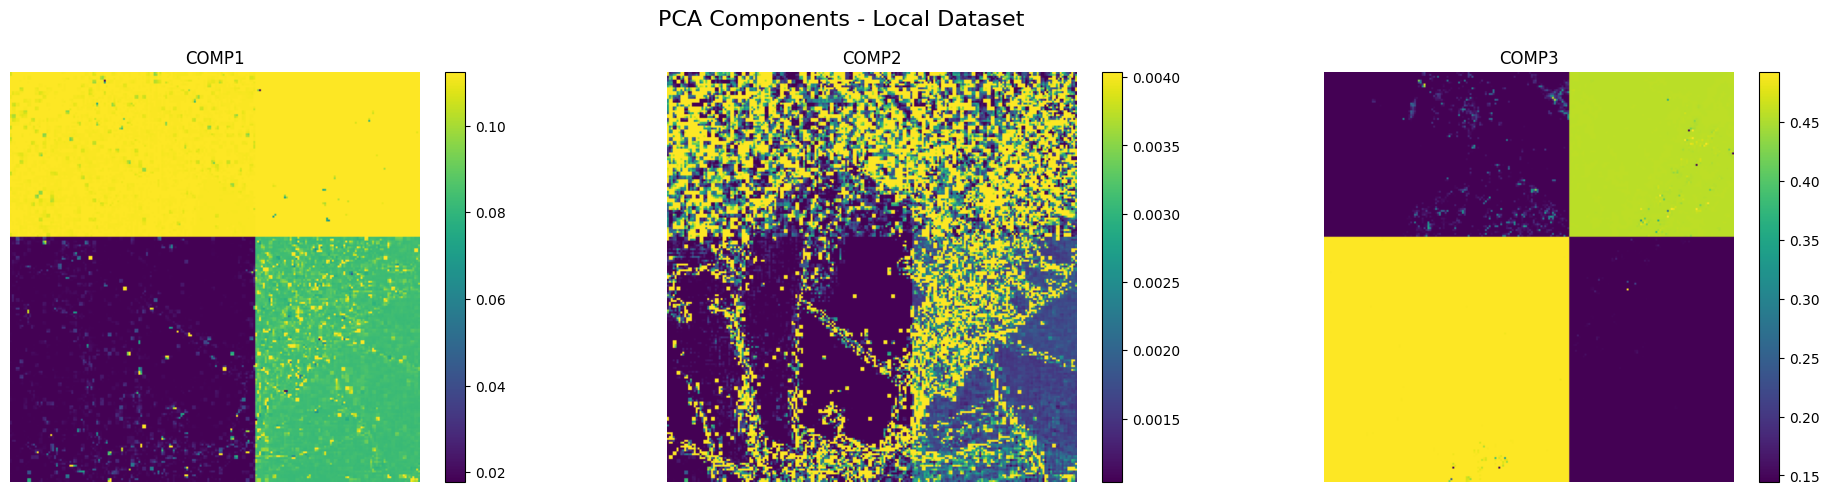

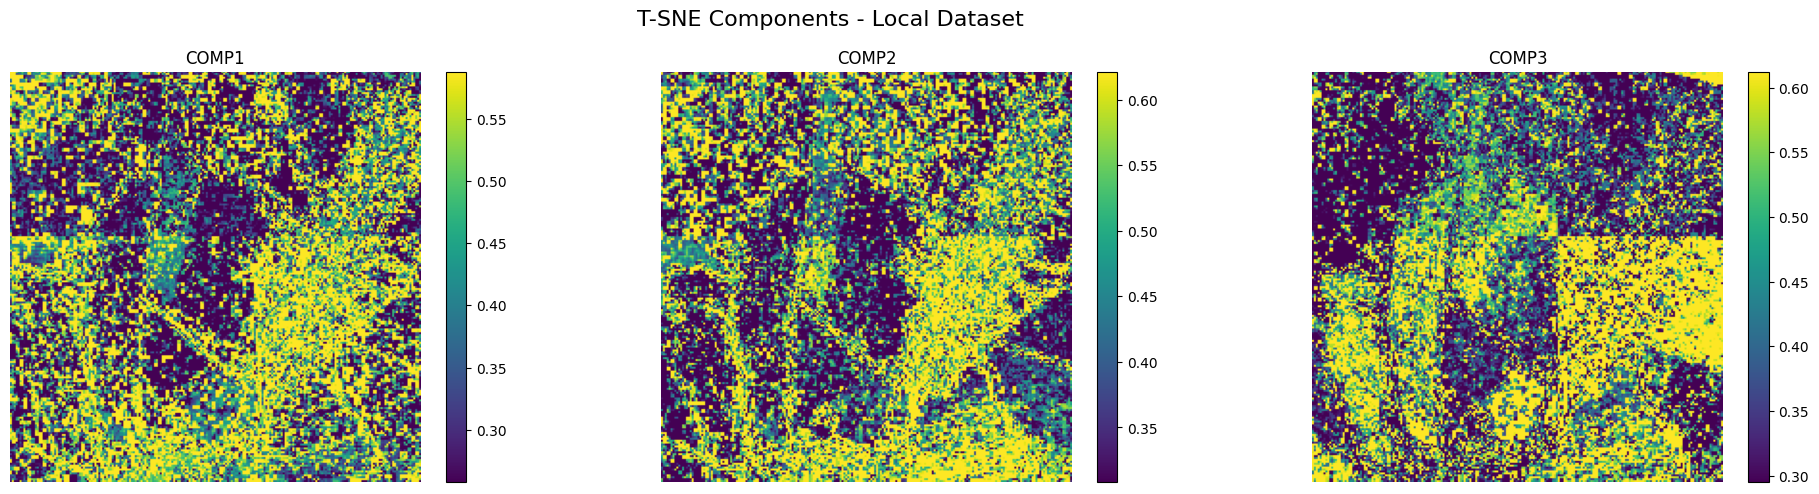

In [152]:
# pca_job_data_array = pca_job_data['__xarray_dataarray_variable__']
# tsne_job_data_array = tsne_job_data['__xarray_dataarray_variable__']

def plot_components(data_array: str, model_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, ax in enumerate(axes):
        comp_data = data_array.isel(bands=i)
        # Use percentiles to plot as vmin & vmax to highlight differences
        vmin = comp_data.quantile(0.25).item()
        vmax = comp_data.quantile(0.75).item()
        
        im = ax.imshow(comp_data, origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f'COMP{i+1}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add a general title
    fig.suptitle(model_name + " Components - Local Dataset", fontsize=16)

    plt.tight_layout()
    plt.show()

plot_components(pca_job_data_array, "PCA")
plot_components(tsne_job_data_array, "T-SNE")